# ATIVIDADE PONTUADA 4
Aluno: Davi Araújo do Nascimento\
Matrícula: 202300027801

## Questão única

### Funções Auxiliares
Nesta seção encontram-se as funções auxiliares que não estão particulamente associadas a nenhum algoritmo.

In [1]:
# Estas são as importanções que serão usadas na implementação da Transformada Circular de Hough e nas funções auxiliares.
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
# Usa o matplotlib para mostrar a matriz com texto dos valores de cada elemento
def mostrarValoresMatriz(matriz: np.ndarray, cmap=plt.cm.Blues):
    _, ax = plt.subplots()

    ax.matshow(matriz, cmap=cmap)

    for pos, i in np.ndenumerate(matriz):
        ax.text(pos[1], pos[0], str(int(i)), va="center", ha="center")

In [3]:
# Pesos RGB para converter uma imagem colorida em preto-e-branco
PESOS_NTSC = [0.299, 0.587, 0.114]
PESOS_HDTV = [0.2126, 0.7152, 0.0722]
PESOS_HDR  = [0.2627, 0.6780, 0.0593]

# Converte uma imagem para preto-e-branco usando uma distribuição de pesos para as três cores
def converterParaCinza(imagem: np.ndarray, pesos=PESOS_HDR) -> np.ndarray:
    if len(imagem.shape) <= 2:
        return imagem

    if imagem.shape[2] < 3:
        return imagem

    copia = imagem.copy()

    # Pegando os canais individuais de cada cor
    r = copia[:, :, 0] * pesos[0]
    g = copia[:, :, 1] * pesos[1]
    b = copia[:, :, 2] * pesos[2]
    
    return r + g + b

In [4]:
# Calcula a posição do centro da matriz. Se ela possui alguma dimensão ímpar, a posição mais próxima a origem é preferida
def calcularCentro(matriz: np.ndarray) -> (int, int):
    return (
        matriz.shape[0] // 2,
        matriz.shape[1] // 2
    )

In [5]:
# Função que sobrepõe uma matriz em cima de outra numa posição especifica e retorna a fatia sobreposta relevante de cada matriz

def sobreposicao(baixo: np.ndarray, cima: np.ndarray , pos: (int, int) = None) -> (np.ndarray, np.ndarray):
    if baixo.shape[0] < cima.shape[0] or baixo.shape[1] < cima.shape[1]:
        raise Exception("Matriz de cima maior que a de baixo")
    
    if pos == None:
        pos = calcularCentro(baixo)
    
    centro_circ = calcularCentro(cima)

    # Borda da matriz de baixo
    borda_bxo = [
        pos[0] - centro_circ[0],                  # Topo
        pos[0] - centro_circ[0] + cima.shape[0],  # Fundo
        pos[1] - centro_circ[1],                  # Esquerda 
        pos[1] - centro_circ[1] + cima.shape[1]   # Direita
    ]

    # Borda da matriz de cima
    borda_cma = [                                 # O mesmo de cima vale aqui
        0, 
        cima.shape[0],
        0, 
        cima.shape[1] 
    ]               

    # Checando se não passou de mais do topo
    if borda_bxo[0] < 0:
        borda_cma[0] = -borda_bxo[0] 
        borda_bxo[0] = 0

    # Checando se não passou de mais do fundo
    elif borda_bxo[1] > baixo.shape[0]:
        borda_cma[1] -= borda_bxo[1] - baixo.shape[0]
        borda_bxo[1] = baixo.shape[0]

    # Checando se não passou de mais da esquerda
    if borda_bxo[2] < 0:
        borda_cma[2] = -borda_bxo[2] 
        borda_bxo[2] = 0

    # Checando se não passou de mais da direita
    elif borda_bxo[3] > baixo.shape[1]:
        borda_cma[3] -= borda_bxo[3] - baixo.shape[1]
        borda_bxo[3] = baixo.shape[1]

    return (
        baixo[
            borda_bxo[0] : borda_bxo[1], 
            borda_bxo[2] : borda_bxo[3],
        ], 
        cima[
            borda_cma[0] : borda_cma[1],
            borda_cma[2] : borda_cma[3],
        ]
    )

### Implementação Transforma Circular de Hough
Nesta seção encontram-se as principais funções utilizadas na implementação

In [6]:
# Cria uma matriz com uma circunferência inscrita dentro
def gerarCircunferencia(raio: int) -> np.ndarray:
    diametro = raio * 2 - 1
    grade_x, grade_y = np.mgrid[:diametro, :diametro]
    
    saida = np.zeros((diametro, diametro))
    correcao_raio = raio - 1

    # Usando o código mágico do numpy e a equação do círculo
    saida[(grade_x - correcao_raio) ** 2 + (grade_y - correcao_raio) ** 2 <= raio ** 2] = 1

    # Removendo o circulo interior para formar a circunferencia
    saida[(grade_x - correcao_raio) ** 2 + (grade_y - correcao_raio) ** 2 < (raio - 1) ** 2] = 0

    return saida

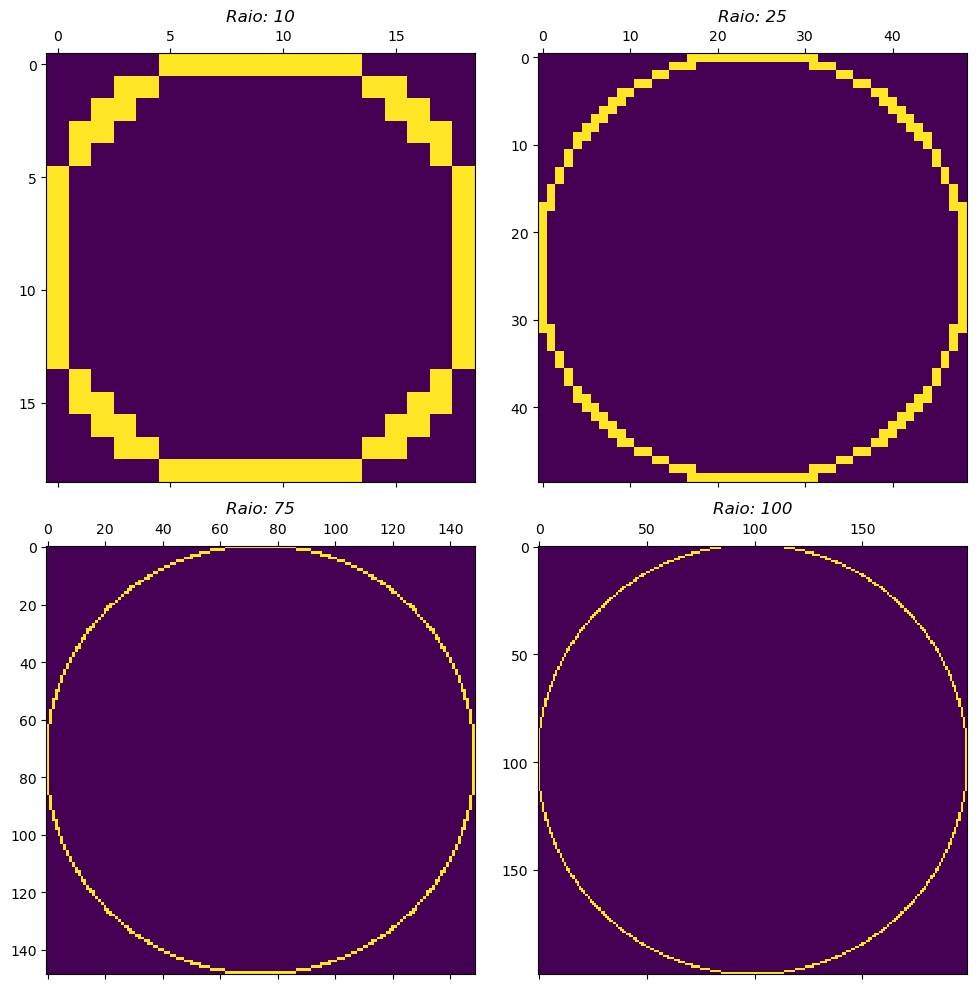

In [7]:
# Demonstração do funciomento da função acima

demo_raios           = [ 10, 25, 75, 100 ]
demo_circunferencias = []

# Gerando circunferências com base nos raios 
for i in demo_raios:
    demo_circunferencias.append(gerarCircunferencia(i))

# Organizando as imagens
tamanho = 10
colunas = 2
linhas  = len(demo_raios) // colunas

fig, eixos = plt.subplots(linhas, colunas, figsize=(tamanho, tamanho))

for pos, eixo in np.ndenumerate(eixos):
    indice_1d = pos[0] * colunas + pos[1]
    eixo.set_title(f"Raio: {demo_raios[indice_1d]}", fontstyle="italic")
    eixo.matshow(demo_circunferencias[indice_1d])

fig.tight_layout()

A circunferência de 100 não parece ter o topo mas tem. \
Por algum motivo o matplotlib corta um pedaço da parte superior da imagem. \
Dá para perceber isso na circunferência de raio 75

In [8]:
# Usa as funções acima para gerar o acumulador da Transformada Circular de Hough

def gerarAcumulador(imagem: np.ndarray, raio: int) -> np.ndarray:
    acumulador = np.zeros(imagem.shape)
    circunferencia = gerarCircunferencia(raio)

    # Somando a circunferencia em cima 
    for pos, i in np.ndenumerate(imagem):
        if i != 0: 
            baixo, cima = sobreposicao(acumulador, circunferencia, pos)
            baixo += cima

    return acumulador

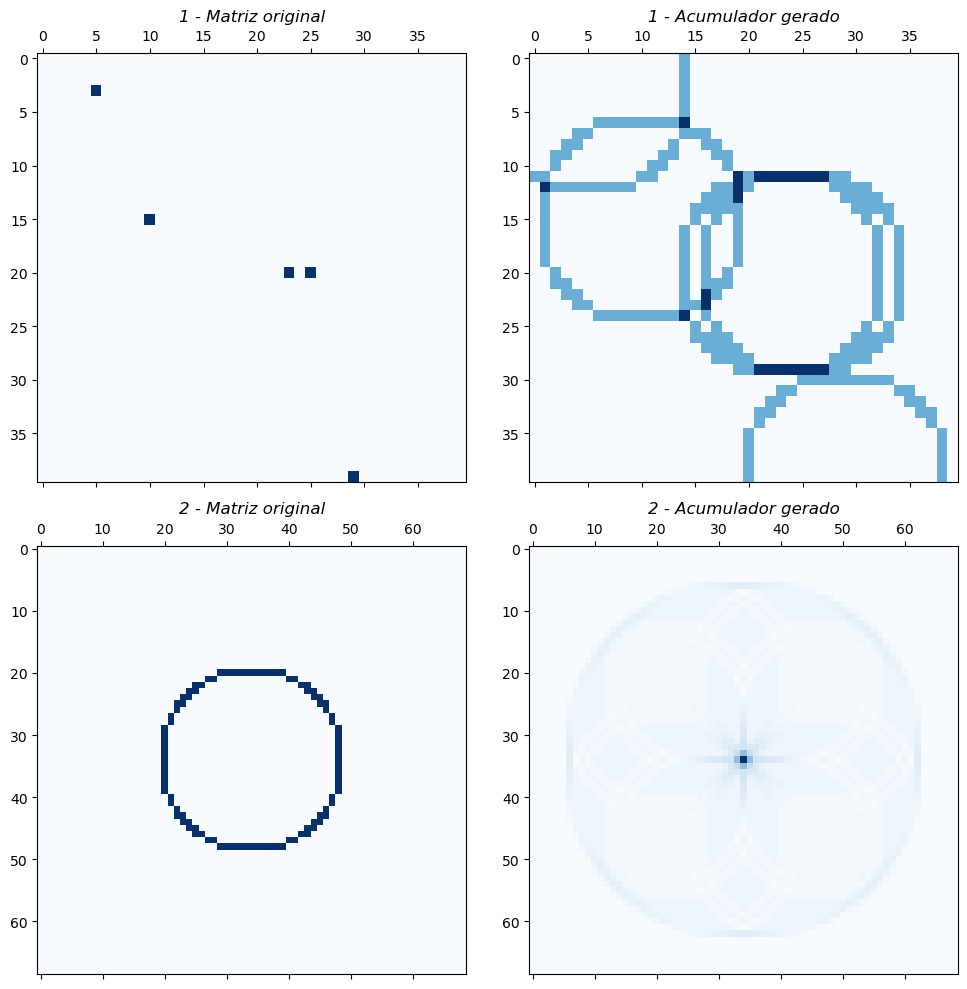

In [9]:
# Demonstração da função a cima

demo_pontos = [
    (3, 5),
    (15, 10),
    (39, 29),
    (20, 23),
    (20, 25)
]

demo_matriz         = np.zeros((40, 40))
demo_circunferencia = np.pad(gerarCircunferencia(15), ((20, 20), (20, 20)))

# Posicionando os pontos
for i in demo_pontos:
    demo_matriz[i] = 1

# Organizando as imagens
tamanho = 10
colunas = 2
linhas  = 2

fig, eixos = plt.subplots(linhas, colunas, figsize=(tamanho, tamanho))

demo_infos = [
    ("1 - Matriz original", demo_matriz),
    ("2 - Matriz original", demo_circunferencia),
    ("1 - Acumulador gerado", gerarAcumulador(demo_matriz, 10)),
    ("2 - Acumulador gerado", gerarAcumulador(demo_circunferencia, 15))
]

for pos, i in enumerate(demo_infos):
    col = pos // colunas
    lin = pos % colunas

    eixos[lin, col].set_title(i[0], fontstyle="italic")
    eixos[lin, col].matshow(i[1], cmap=plt.cm.Blues)

fig.tight_layout()

In [10]:
# Função auxiliar. Checa se o centro de uma matriz é o valor máximo dentro dela mesma

def testarMaximoCentral(matriz: np.ndarray) -> bool:
    # Capturando o valor do centro
    centro = matriz[calcularCentro(matriz)]

    # Checando até achar um valor maior que o centro
    for i in np.nditer(matriz):
        if i > centro:
            return False

    # Se não achar 
    return True

In [11]:
# Conta quantos máximos locais têm numa matriz
# Estratégia: definir um valor mínimo para que um elemento da matriz possa ser considerado elegível como ponto máximo. 
# Esse valor é calculado a partir da variável margem e o valor máximo da matriz inteira. 
# Eu achei que 0.5 tá num valor legal como padrão, por isso esse parâmetro tá como opcional.
# Depois é testado se o elemento é um ponto máximo dentro de uma área ao seu ao redor.
# Caso seja, é somado mais um no contador e a área é apagada do acumulador.

def contarMaximosLocais(acumulador: np.ndarray, raio: int, margem: float = 0.5) -> (np.ndarray, int):
    if not 0 <= margem < 1:
        raise Exception("A margem deve estar contida dentro do intervalo [0, 1)")

    copia = acumulador.copy()                   # Criando cópia pois o acumulador será alterado
    cont = 0                                    # Contagem de pontos máximos
    diametro = 2 * raio - 1                     # Diametro da área de análise
    area = np.zeros((diametro, diametro))       # Matriz que será usada como referência para extrair a área sobreposta do acumulador
    valor_min = int(copia.max() * (1 - margem)) # Valor mínimo para um elemento ser elegível

    for pos, i in np.ndenumerate(copia):
        if i < valor_min: continue
        
        baixo, _ = sobreposicao(copia, area, pos)

        if testarMaximoCentral(baixo): 
            cont += 1
            baixo *= 0 # Apagando área

    return (copia, cont)

### Tratamento da imagem e finalização da função da Transformada Circular de Hough

In [12]:
# Calcula e retorna o valor de um ponto na distribuição normal

def funcaoGaussiana(x: float, sigma: float) -> float:
    aux = (x ** 2) / (2 * sigma ** 2)
    aux = np.exp(-aux)

    return aux / np.sqrt(2 * np.pi)

In [13]:
# Gera núcleo para o desfoque gaussiano

def gerarNucleo(raio: int, sigma: float) -> np.ndarray:
    nucleo_1d = np.ndarray((raio * 2 - 1, 1))

    for i in range(-(raio - 1), raio):
        nucleo_1d[i + raio - 1] = funcaoGaussiana(i, sigma)

    return nucleo_1d * nucleo_1d.transpose()

In [14]:
def convolucao2d(matriz_a: np.ndarray, matriz_b: np.ndarray):
    pass

In [15]:
def desfoqueGaussiano(imagem: np.ndarray, nucleo: np.ndarray) -> np.ndarray:
    pass

In [16]:
def gradienteIntensidade(imagem: np.ndarray):
    pass

In [17]:
def supressao(imagem: np.ndarray):
    pass

In [18]:
def limiteDuplo(imagem: np.ndarray):
    pass

In [19]:
def canny(imagem: np.ndarray) -> np.ndarray:
    nucleo_gauss = gerarNucleo(3, 2) 

    etapa = converterParaCinza(imagem)
    etapa = desfoqueGaussiano(etapa, nucleo_gauss)
    etapa = gradienteIntensidade(etapa)
    etapa = supressao(etapa)

    return limiteDuplo(etapa)

Não sei se era somente a Tranformada Circular de Hough que é para ser feita usando somente as operações do Numpy ou se não pode usar em nada. Para ter certeza eu iria implementar a detecção de bordas também. \
Infelizmente, não vou conseguir ter tempo de terminar essa parte mas o principal está feito apenas com as operações do Numpy, por isso só importo as funções prontas agora. \
Talvez o operador Sobel funcione mas prefiro não usar porque a função canny é bem mais robusta.

In [20]:
from skimage.feature import canny

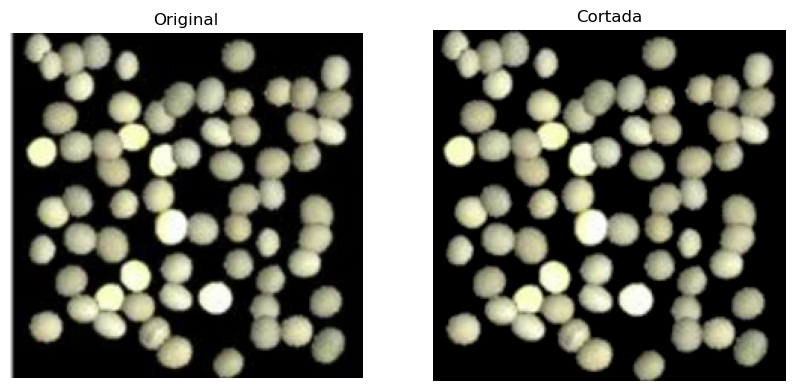

In [25]:
# Demonstração inteira do processo

# Carregando imagem da especificação
sementes_original = imread("sementes.png")

# Cortando imagem porque ela vem com uma linha branca na esquerda que atrapalha a detecção
sementes_cortada = sementes_original.copy()[:, 4:, :]

# Removendo um pouco do ruido na parte preta da imagem
sementes_cortada[sementes_cortada < 20] = 0

# Organizando as imagens
tamanho = 10
colunas = 2
linhas  = 1

fig, eixos = plt.subplots(linhas, colunas, figsize=(tamanho, tamanho))

eixos[0].set_title("Original")
eixos[1].set_title("Cortada")

eixos[0].axis("off")
eixos[1].axis("off")

eixos[0].imshow(sementes_original)
eixos[1].imshow(sementes_cortada)


    Resultados:

    Quantidade de sementes na imagem: 67
    Quantidade de sementes contadas pelo algoritmo: 68
    Precisão: 98.51%



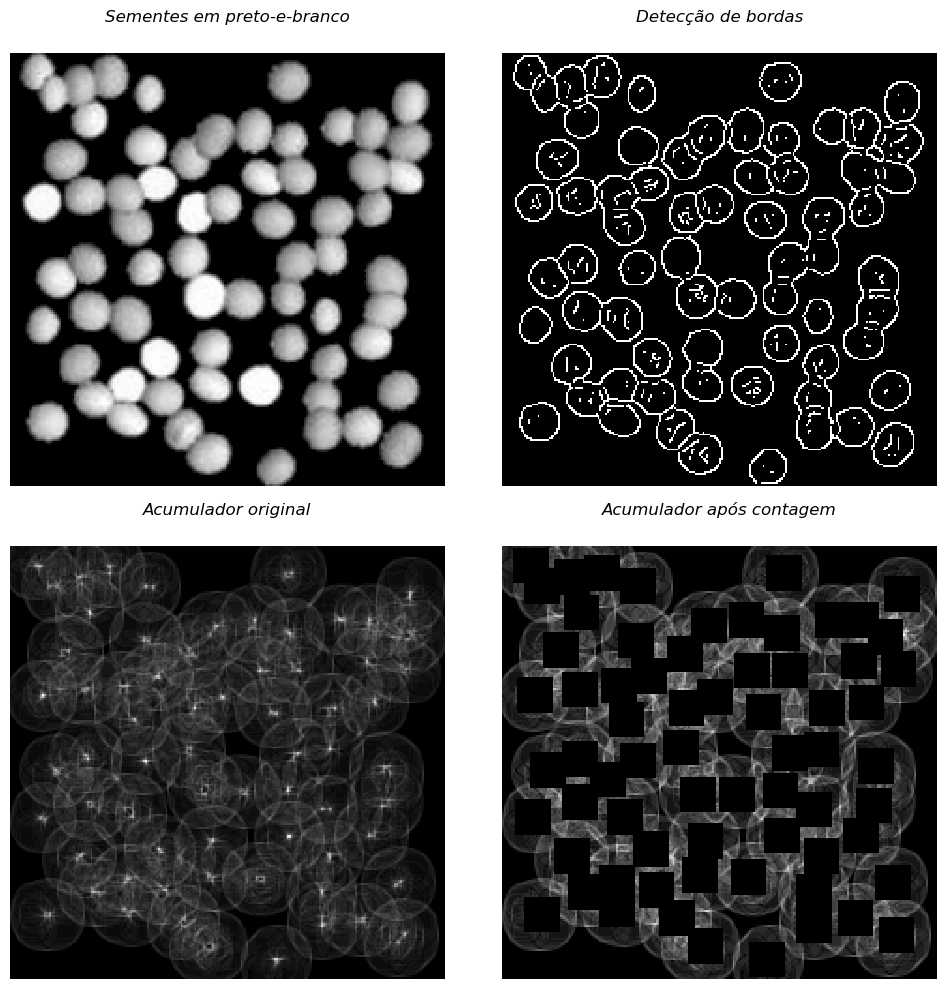

In [31]:
# Parâmetros
qntd_sementes_real  = 67              # Contado manualmente por mim
intesidade_desfoque = 1               # Achei um valor legal
raio_acumulador     = 10              # Os raios da sementes variam entre 9 e 11, então coloquei o valor intermediário
raio_contagem       = raio_acumulador # Percebi que colocando os dois como o mesmo valor dá certo

sementes_cinza      = converterParaCinza(sementes_cortada)                    # Convertendo imagem para cinza
sementes_bordas     = canny(sementes_cinza, sigma=intesidade_desfoque)        # Aplicando a detecção de borda Canny
sementes_acumulador = gerarAcumulador(sementes_bordas, raio_acumulador)       # Gerando o acumulador baseado nas bordas
resultados          = contarMaximosLocais(sementes_acumulador, raio_contagem) # Obtendo resultados 
precisao            = 1 - abs(1 - resultados[1] / qntd_sementes_real)


print(f"""
    Resultados:\n
    Quantidade de sementes na imagem: {qntd_sementes_real}
    Quantidade de sementes contadas pelo algoritmo: {resultados[1]}
    Precisão: {(precisao * 100):.2f}%
""")

# Organizando imagens
tamanho = 10
colunas = 2
linhas  = 2

infos = [
    ("Sementes em preto-e-branco", sementes_cinza),
    ("Acumulador original", sementes_acumulador),
    ("Detecção de bordas", sementes_bordas),
    ("Acumulador após contagem", resultados[0])
]

fig, eixos = plt.subplots(linhas, colunas, figsize=(tamanho, tamanho))

for pos, i in enumerate(infos):
    col = pos // colunas
    lin = pos % colunas

    eixos[lin, col].set_title(i[0], fontstyle="italic")
    eixos[lin, col].axis("off")
    eixos[lin, col].matshow(i[1], cmap="gray")

fig.tight_layout()

## Referências

https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap \
https://stackoverflow.com/questions/10031580/how-to-write-simple-geometric-shapes-into-numpy-arrays \
https://www.youtube.com/watch?v=Ltqt24SQQoI \
https://numpy.org/devdocs/reference/ \
https://stackoverflow.com/questions/53124061/how-can-i-add-a-small-matrix-into-a-big-one-with-numpy \
https://en.wikipedia.org/wiki/Canny_edge_detector \
https://iust-projects.ir/post/dip05/ \
https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html \
https://en.wikipedia.org/wiki/Gaussian_function \
https://en.wikipedia.org/wiki/Gaussian_blur \
https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale \
https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python \
https://stackoverflow.com/questions/17615963/standard-rgb-to-grayscale-conversion \
https://docs.scipy.org/doc/scipy/index.html \
https://www.reddit.com/r/learnpython/comments/evc9tj/how_to_use_the_float_command_to_create_2_decimal/